<a href="https://colab.research.google.com/github/yashclone999/ResNet_MODEL/blob/master/ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **SKIP CONNECTIONS**
* Deep neural networks are difficult to train, and one major problem they suffer from is vanishing-gradients(or exploding-gradients as well). The absolute value of the Gradient signal tends to decrease exponentially as we move from the last layer to the first, which makes the gradient descent process extremely slow
*   Introducing ResNet blocks with "skip-connections" in very deep neural nets helps us address the problem of vanishing-gradients and also accounts for an ease-of-learning in very deep NNs. The intuition behind why this works is that a residual-network block with a skip-connection can learn the identity function (capable of outputting its input as it is). So adding the residual block to the network poses little risk to the learning performance of the network



This notebook implements a fifty-layer Deep Neural Network, with *skip-connections*. Its core building blocks are three-layered *identity blocks* and three-layered *convolutional blocks* with skip-connections


# **IMPORTS**
We will use Keras (Tensorflow 2) for building our ResNet model and h5py to load data

In [ ]:
import os
import h5py
import math
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import glorot_uniform
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

%matplotlib inline
import tensorflow.keras.backend as K
# Image dataset has channels as its last dimensions
K.set_image_data_format('channels_last')

# **LOAD DATA**
SIGNS Dataset 

In [ ]:
def load_dataset():
    train_dataset = h5py.File('/content/drive/MyDrive/ResNet50/datasets/train_signs.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # train set labels

    test_dataset = h5py.File('/content/drive/MyDrive/ResNet50/datasets/test_signs.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # test set labels

    # list of classes
    classes = np.array(test_dataset["list_classes"][:]) 

    # reshape 
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0])) 
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0])) 

    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [ ]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

In [ ]:
def plotImages(images_arr, labels):
  fig, axes = plt.subplots(1,10, figsize=(20,20))
  axes = axes.flatten()
  for ax, img in zip(axes, images_arr):
    ax.imshow(img)
    ax.axis('off')
  plt.tight_layout()
  plt.show()
  print(labels[0][0:10])

In [ ]:
train_set_x_orig, Y_train_orig, test_set_x_orig, Y_test_orig, classes = load_dataset()

# normalize image vectors
X_train = train_set_x_orig/255 
X_test  = test_set_x_orig/255

# Convert training and test labels to one hot matrices
Y_train = convert_to_one_hot(Y_train_orig, classes.shape[0]).T
Y_test = convert_to_one_hot(Y_test_orig, classes.shape[0]).T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
# Note channels are last dimensions for images 
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


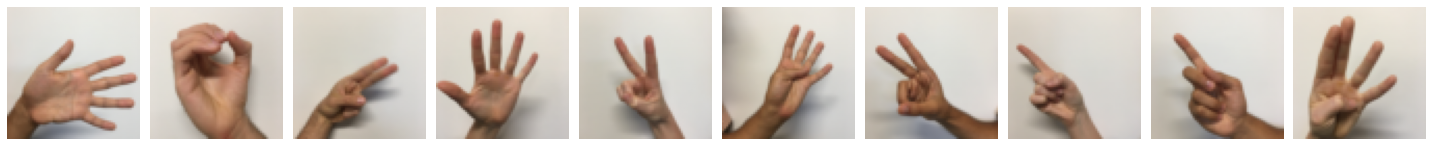

[5 0 2 5 2 4 2 1 1 4]


In [ ]:
plotImages(X_train, Y_train_orig)

# **IDENTITY BLOCK**
A block of layers with skip connection, where the input activation (say *a[i]*) has the same dimension as the output activation (say *a[i+n]* where n is number of layers in the block) is an identity block in a ResNet.
The skip-connection or shortcut is reffered to the path 1 in the figure. While path 2 is the main path.

**Structure of our identity block**

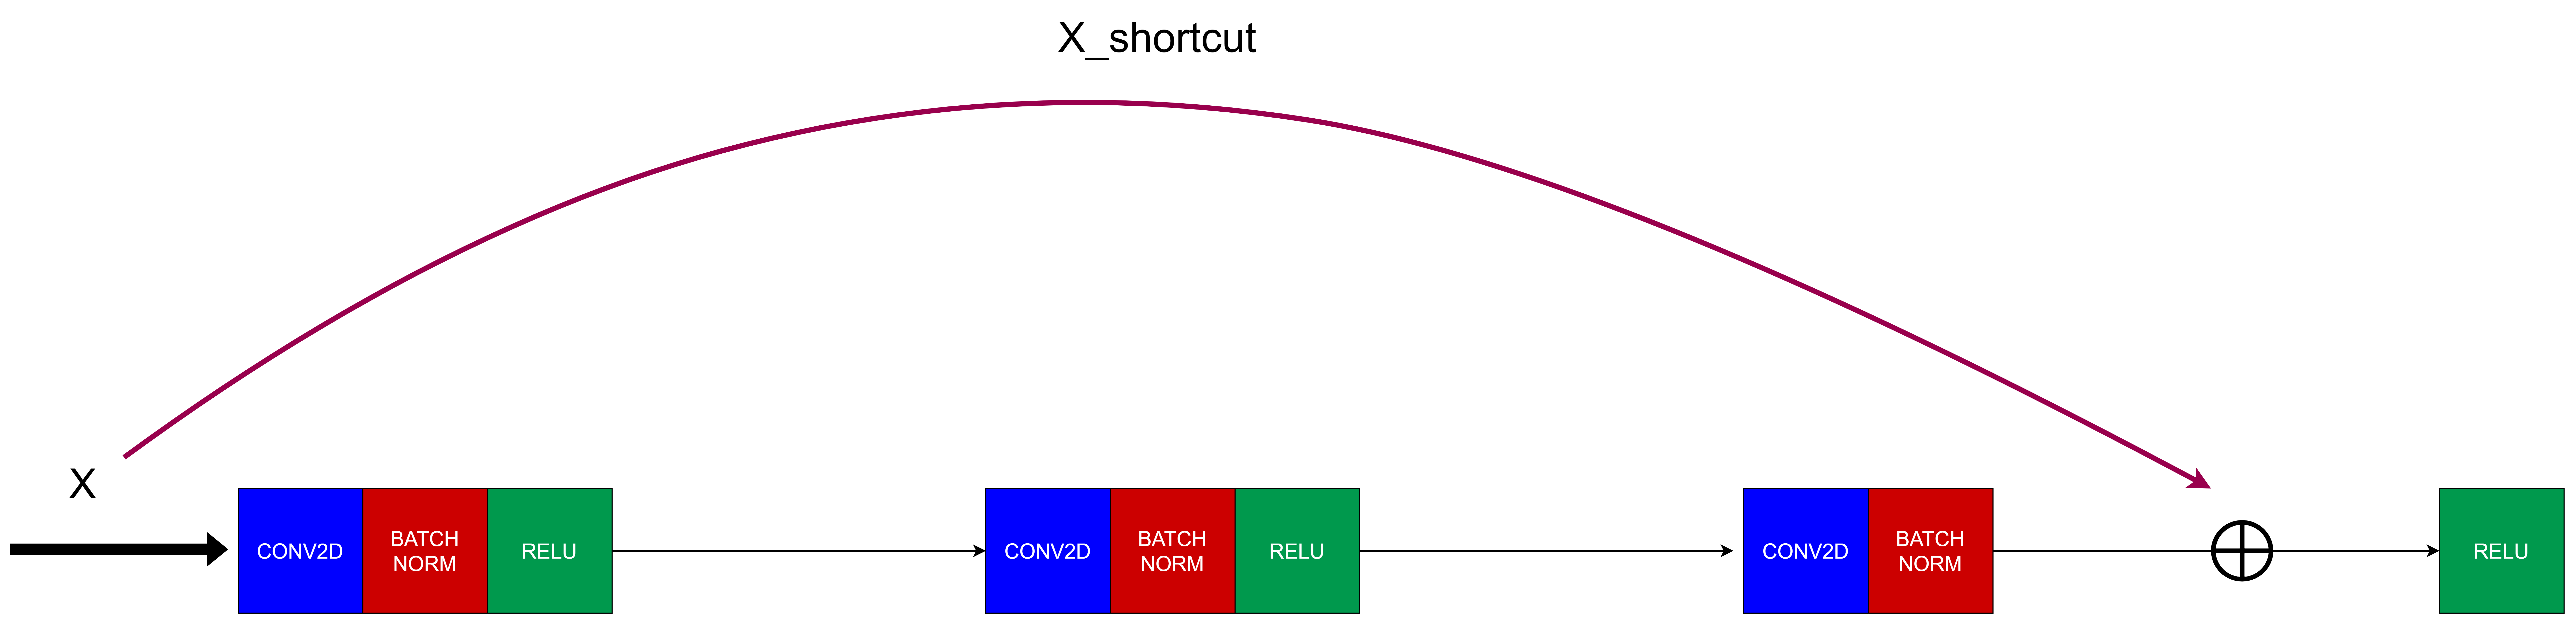

In [ ]:
def identity_block(X, f, filters, stage, block):

  '''
  Implementation of identity block described above

  Arguments:
  X -       input tensor to the block of shape (m, n_H_prev, n_W_prev, n_C_prev)
  f -       defines shpae of filter in the middle layer of the main path
  filters - list of integers, defining the number of filters in each layer of the main path
  stage -   defines the block position in the network
  block -   used for naming convention

  Returns: 
  X - output is a tensor of shape (n_H, n_W, n_C) which matches (m, n_H_prev, n_W_prev, n_C_prev)
  '''

  # defining base name for block
  conv_base_name = 'res' + str(stage) + block + '_'
  bn_base_name = 'bn' + str(stage) + block + '_'

  # retrieve number of filters in each layer of main path
  # NOTE: f3 must be equal to n_C. That way dimensions of the third component will match the dimension of original input to identity block
  f1, f2, f3 = filters

  # Batch normalization must be performed on the 'channels' axis for input. It is 3, for our case
  bn_axis = 3

  # save input for "addition" to last layer output; step in skip-connection
  X_skip_connection = X

  # ----------------------------------------------------------------------
  # Building layers/component of identity block using Keras functional API

  # First component/layer of main path
  X = Conv2D(filters= f1, kernel_size = (1,1), strides = (1,1), padding='valid', name=conv_base_name+'first_component', kernel_initializer = glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis=bn_axis, name=bn_base_name+'first_component')(X)
  X = Activation('relu')(X)
  
  # Second component/layer of main path
  X = Conv2D(filters= f2, kernel_size = (f,f), strides = (1,1), padding='same', name=conv_base_name+'second_component', kernel_initializer = glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis=bn_axis, name=bn_base_name+'second_component')(X)
  X = Activation('relu')(X)

  # Third component/layer of main path
  X = Conv2D(filters= f3, kernel_size = (1,1), strides = (1,1), padding='valid', name=conv_base_name+'third_component', kernel_initializer = glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis=bn_axis, name=bn_base_name+'third_component')(X)
  
  # "Addition step" - skip-connection value merges with main path
  # NOTE: both values have same dimensions at this point, so no operation is required to match dimensions
  X = Add()([X, X_skip_connection])
  X = Activation('relu')(X)

  return X

# **CONVOLUTIONAL** **BLOCK**

This is another kind of block with skip-connection in the ResNet. In this the input to block, and output of last layer in the block don't match in dimensions. So we need to add a convolution step in the skip-connection, before adding the input to last layer's output. This convolution step changes the dimension of the input, so that the dimensions match up for the later addition step.

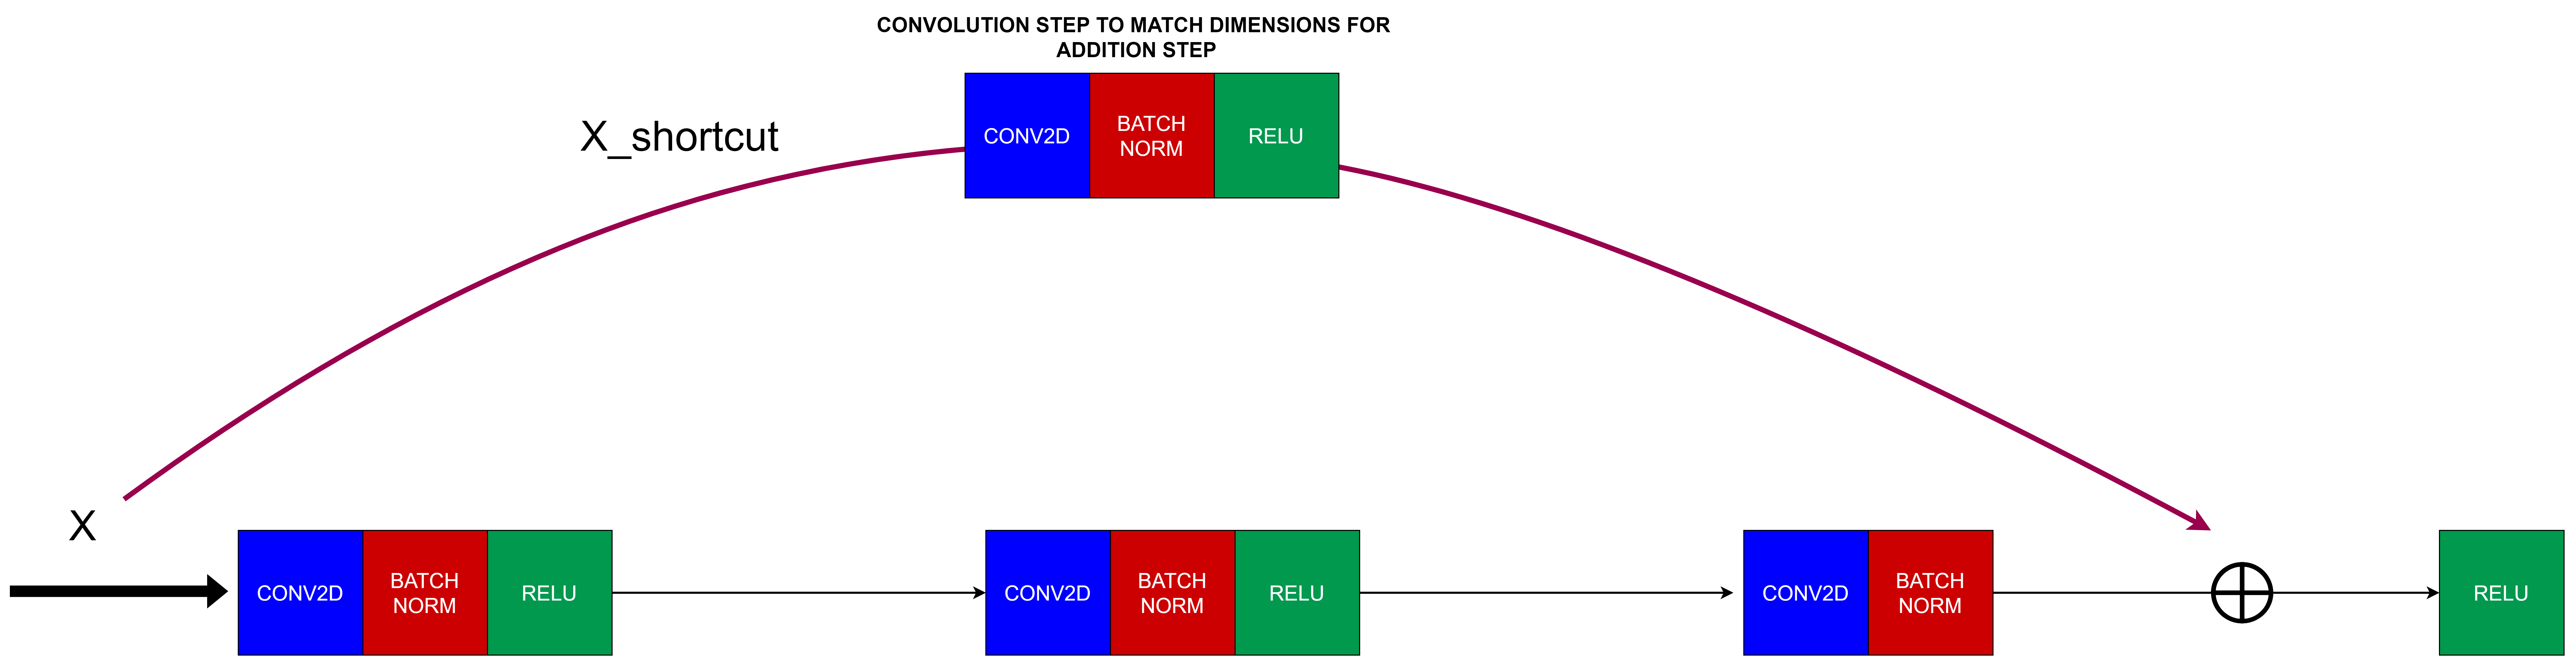

In [ ]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in above figure
    
    Arguments:
    X -       input tensor to the block of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -       defines shape of filter in the middle layer of the main path
    filters - list of integers, defining the number of filters in each layer of the main path
    stage -   defines the block position in the network
    block -   used for naming convention
    s -       specifies the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining base name for block
    conv_base_name = 'res' + str(stage) + block + '_'
    bn_base_name = 'bn' + str(stage) + block + '_'
    
    # retrieve number of filters in each layer of main path
    f1, f2, f3 = filters
    
    # Batch normalization must be performed on the 'channels' axis for input. It is 3, for our case
    bn_axis = 3

    # save input for "addition" to last layer output; step in skip-connection
    X_skip_connection = X

    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(f1, (1, 1), strides = (s,s), padding = 'valid', name = conv_base_name + 'first_component', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = bn_axis, name = bn_base_name + 'first_component')(X)
    X = Activation('relu')(X)
    
    # Second component of main path
    X = Conv2D(f2,  kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_base_name + 'second_component', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = bn_axis, name = bn_base_name + 'second_component')(X)
    X = Activation('relu')(X)

    # Third component of main path 
    X = Conv2D(f3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_base_name + 'third_component', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = bn_axis, name = bn_base_name + 'third_component')(X)

    ##### Convolve skip-connection value to match its dimensions to third layer output's dimensions #### 
    X_skip_connection = Conv2D(f3, (1, 1), strides = (s,s), padding = 'valid', name = conv_base_name + 'merge', kernel_initializer = glorot_uniform(seed=0))(X_skip_connection)
    X_skip_connection = BatchNormalization(axis = 3, name = bn_base_name + 'merge')(X_skip_connection)

    # "Addition step" 
    # NOTE: both values have same dimensions at this point
    X = Add()([X, X_skip_connection])
    X = Activation('relu')(X)

    return X

# **RESNET50** 
Now that we have our building blocks - Convolutional block and identity block in place, we will build a 50 layer deep neural network with skip connections that implements the follwoing architecture 

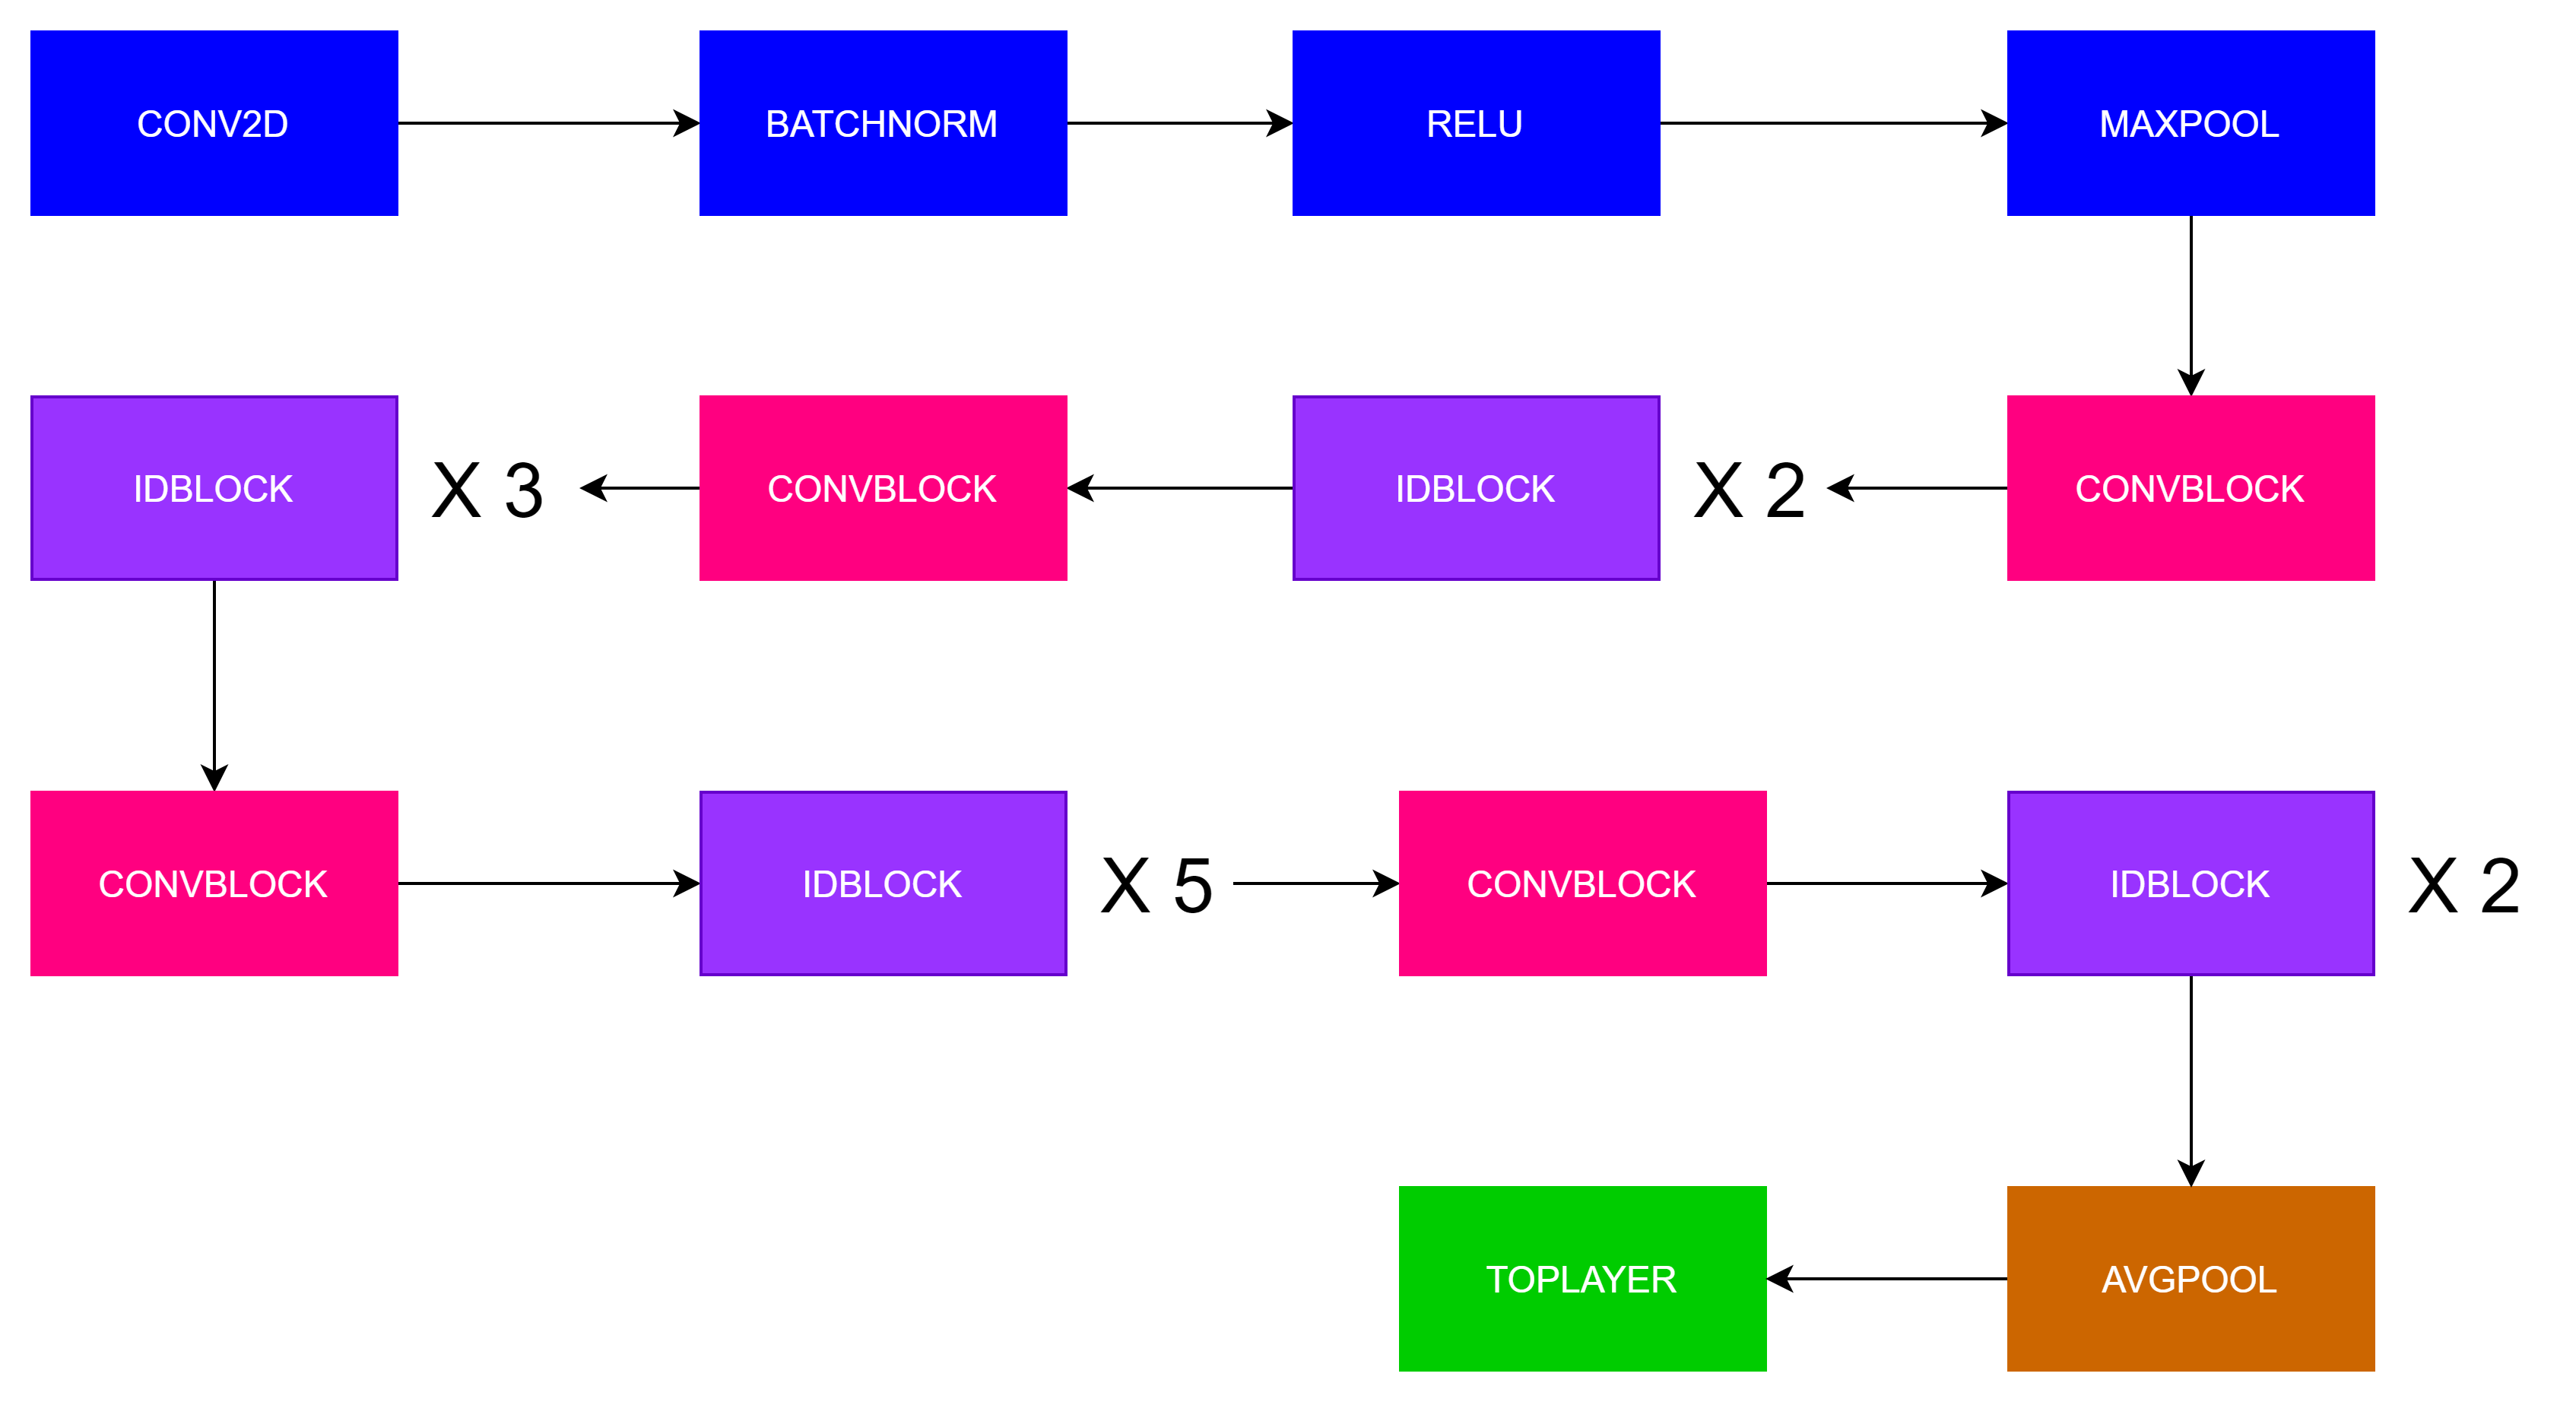

In [ ]:
def ResNet50(input_shape = (64, 64, 3), classes = 6):
    """
    Arguments:
    input_shape - shape of the images of the dataset
    classes - number of classes

    Returns:
    model - a Model() instance in Keras
    
    """
    
    # plug in input_shape to define the input tensor
    X_input = Input(input_shape)

    # Zero-Padding : pads the input with a pad of (3,3)
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv_1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # NOTE: dimensions of filters that are passed to identity block are such that final layer output
    # in identity block mathces the original input to the block
    # blocks in each stage are alphabetically sequenced

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    # Stage 3
    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4
    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5
    X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # Average Pooling
    X = AveragePooling2D((2, 2), name='avg_pool')(X)

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [ ]:
model = ResNet50(input_shape = (64, 64, 3), classes = 6)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# **TRAIN** **RESNET50**

In [ ]:
model.fit(X_train, Y_train, epochs = 20, batch_size = 32)

Epoch 1/20
34/34 [==============================] - 186s 5s/step - loss: 1.9862 - accuracy: 0.4491
Epoch 2/20
34/34 [==============================] - 176s 5s/step - loss: 0.5991 - accuracy: 0.7981
Epoch 3/20
34/34 [==============================] - 177s 5s/step - loss: 0.3626 - accuracy: 0.8806
Epoch 4/20
34/34 [==============================] - 172s 5s/step - loss: 0.2499 - accuracy: 0.9222
Epoch 5/20
34/34 [==============================] - 172s 5s/step - loss: 0.3940 - accuracy: 0.8843
Epoch 6/20
34/34 [==============================] - 172s 5s/step - loss: 0.3055 - accuracy: 0.9139
Epoch 7/20
34/34 [==============================] - 179s 5s/step - loss: 0.1642 - accuracy: 0.9435
Epoch 8/20
34/34 [==============================] - 174s 5s/step - loss: 0.1361 - accuracy: 0.9546
Epoch 9/20
34/34 [==============================] - 177s 5s/step - loss: 0.2177 - accuracy: 0.9444
Epoch 10/20
34/34 [==============================] - 179s 5s/step - loss: 0.0550 - accuracy: 0.9815
Epoch 11/

In [ ]:
model.save('/content/drive/MyDrive/ResNet50/model/RESNET50.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


# **TEST** **PERFORMANCE**

In [ ]:
predictions = model.evaluate(X_test, Y_test)
print("Loss = " + str(predictions[0]))
print("Test Accuracy = " + str(predictions[1]))

4/4 [==============================] - 3s 392ms/step - loss: 0.2398 - accuracy: 0.9500
Loss = 0.239801824092865
Test Accuracy = 0.949999988079071


In [ ]:
new_model = load_model('/content/drive/MyDrive/ResNet50/model/RESNET50.h5')
predictions = new_model.evaluate(X_test, Y_test)
print(predictions)

4/4 [==============================] - 3s 521ms/step - loss: 0.2398 - accuracy: 0.9500
[0.239801824092865, 0.949999988079071]
